<a href="https://colab.research.google.com/github/ncorriveau/ood_computervision/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Packages

In [5]:
#!pip install --upgrade torchvision==0.13

import torch
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np 
import pandas as pd
import os
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot as plt
import requests
import zipfile
import shutil 


In [1]:
try:
  import timm
except:
  !pip install timm
  import timm

In [2]:
# Continue with regular imports
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


#Mount drive and set paths

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!unzip /content/train.zip
!unzip /content/test.zip

In [3]:
# train_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/train'
# test_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/test'
train_path = '/content/train'
test_path = '/content/test'

In [6]:
#put on gpu if available 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#Data Augmentation and Preparation 

This part assumes that you have already run the data preprocess notebook and have the train and test folders in a format of:
train/superclass/subclass and test/supeclass/subclass

In [6]:
'''uncomment this section if we move forward with more customized training.'''
# train_transforms = train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomGrayscale(0.5),
#     transforms.RandomAdjustSharpness(2, 0.5), # adjust sharpness by a factor of 2 with prob 0.5 of it being adjusted
#     transforms.RandomInvert(p=0.5),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.TrivialAugmentWide(num_magnitude_bins=31), # change intensity of image with max being 31 
#     transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ])

# test_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])


'uncomment this section if we move forward with more customized training.'

In [7]:
'''process below follows:
https://www.learnpytorch.io/06_pytorch_transfer_learning/'''

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_path,
                                                                               test_dir=test_path,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fc3fedbbc10>,
 ['bird', 'dog', 'reptile'])

In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


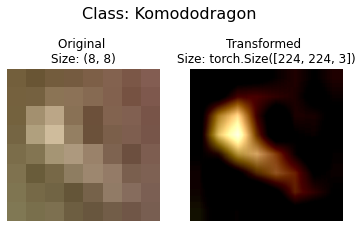

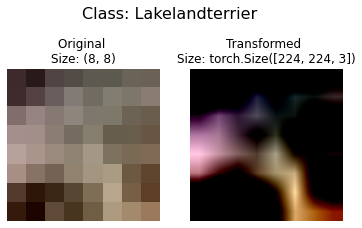

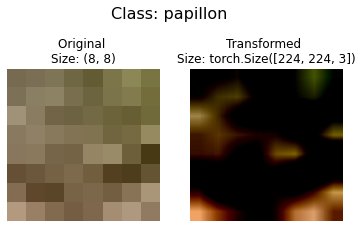

In [11]:
#this returns a posix path to every image in our training directory 
image_paths = list(Path(train_path).glob("*/*/*.jpg"))

plot_transformed_images(image_paths, 
                        transform=manual_transforms,
                        n=3)

#Apply Vision Transformer

### Train Model for SuperClass Classification

In [ ]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

In [12]:
torchvision.__version__

'0.13.0+cu102'

In [13]:
torch.__version__

'1.12.0+cu102'

In [14]:
weights = torchvision.models.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ViT_L_16_Weights.IMAGENET1K_V1

In [15]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [16]:
#create data loaders using the auto transforms from the trained model 
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_path,
                                                                               test_dir=test_path,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fc3fbba5710>,
 ['bird', 'dog', 'reptile'])

In [17]:
model = torchvision.models.vit_l_16(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth


  0%|          | 0.00/1.13G [00:00<?, ?B/s]

In [ ]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           1,024                True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   787,456              True
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              True
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      12,596,224           True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 197, 10

In [18]:
# Freeze all base layers in the "features" section of the model
layers = [model.conv_proj.parameters(), model.encoder.parameters()]
for layer in layers:
  for param in layer:
    param.requires_grad = False

In [19]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.heads = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1024, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
#look at summary again after adjusting our sequential layer 
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              1,024                Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   (787,456)            False
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              False
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      (12,596,224)         False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 

In [ ]:
#set hyperparameters 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1302 | train_acc: 0.3562 | test_loss: 1.0908 | test_acc: 0.3818
Epoch: 2 | train_loss: 1.1050 | train_acc: 0.3773 | test_loss: 1.0800 | test_acc: 0.4056
Epoch: 3 | train_loss: 1.0960 | train_acc: 0.3885 | test_loss: 1.0742 | test_acc: 0.4149
Epoch: 4 | train_loss: 1.0895 | train_acc: 0.4033 | test_loss: 1.0550 | test_acc: 0.4417
Epoch: 5 | train_loss: 1.0806 | train_acc: 0.4139 | test_loss: 1.1027 | test_acc: 0.3921
Epoch: 6 | train_loss: 1.0770 | train_acc: 0.4098 | test_loss: 1.0416 | test_acc: 0.4484
Epoch: 7 | train_loss: 1.0671 | train_acc: 0.4232 | test_loss: 1.0383 | test_acc: 0.4629
Epoch: 8 | train_loss: 1.0652 | train_acc: 0.4326 | test_loss: 1.0731 | test_acc: 0.4200
Epoch: 9 | train_loss: 1.0620 | train_acc: 0.4357 | test_loss: 1.0401 | test_acc: 0.4517
Epoch: 10 | train_loss: 1.0610 | train_acc: 0.4327 | test_loss: 1.0282 | test_acc: 0.4654
[INFO] Total training time: 12088.170 seconds


In [20]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
save_model(model = model,
           target_dir ='/content/drive/MyDrive/NN and DL/projects/Released_Data/',
           model_name = 'vit_l_16_base.pth')

[INFO] Saving model to: /content/drive/MyDrive/NN and DL/projects/Released_Data/vit_l_16_base.pth


###Optimize Network

In [21]:
try:
  import optuna
except:
  !pip install optuna
  import optuna

In [30]:
#define objective to optimize 
MODEL = model
EPOCHS = 5
DEVICE = device = "cuda" if torch.cuda.is_available() else "cpu"
train_loader = train_dataloader
valid_loader = test_dataloader

def objective(trial):

    # Generate the model.
    model = MODEL

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam","SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.heads.parameters(), lr=lr)
    #batch_size=trial.suggest_int("batch_size", 16, 128,step=16)

    criterion=nn.CrossEntropyLoss()
    
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
       
        for batch_idx, (images, labels) in enumerate(train_loader):

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valid_loader):
                # Limiting validation images.
               # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                #    break
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = model(images)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        accuracy = correct / len(valid_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [31]:
#create study for optuna 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

end_time = timer()
print(f"[INFO] Total time to tune hyper parameters: {end_time-start_time:.3f} seconds using {DEVICE}")

df = study.trials_dataframe()
df

[I 2022-12-06 21:20:01,734] A new study created in memory with name: no-name-f06b9366-ba4c-4185-af71-65e305d7e56d
[I 2022-12-06 22:24:55,641] Trial 0 finished with value: 0.42567985166872685 and parameters: {'optimizer': 'Adam', 'lr': 0.07172109916857937}. Best is trial 0 with value: 0.42567985166872685.
[I 2022-12-06 23:29:48,159] Trial 1 finished with value: 0.4558096415327565 and parameters: {'optimizer': 'SGD', 'lr': 0.02978276103308409}. Best is trial 1 with value: 0.4558096415327565.
[I 2022-12-07 00:34:44,945] Trial 2 finished with value: 0.50942521631644 and parameters: {'optimizer': 'SGD', 'lr': 0.005304197434006815}. Best is trial 2 with value: 0.50942521631644.


Accuracy: 0.50942521631644
Best hyperparameters: {'optimizer': 'SGD', 'lr': 0.005304197434006815}
[INFO] Total time to tune hyper parameters: 11683.214 seconds using cuda


,number,value,datetime_start,datetime_complete,duration,params_lr,params_optimizer,state
0,0,0.425680,2022-12-06 21:20:01.736467,2022-12-06 22:24:55.641593,0 days 01:04:53.905126,0.071721,Adam,COMPLETE
1,1,0.455810,2022-12-06 22:24:55.643668,2022-12-06 23:29:48.159106,0 days 01:04:52.515438,0.029783,SGD,COMPLETE
2,2,0.509425,2022-12-06 23:29:48.161270,2022-12-07 00:34:44.944737,0 days 01:04:56.783467,0.005304,SGD,COMPLETE
